In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns


import sys 
sys.path.append(r'..\utils') 
from utils import get_seaad_colors, get_tx_order


In [2]:
out_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20250815_seaad\spatial_density'
os.makedirs(out_dir, exist_ok=True)

In [3]:
isodepth_file = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\isodepth\20250624\20250624_isodepths.csv'
isodepth_df = pd.read_csv(isodepth_file)
isodepth_df = isodepth_df[isodepth_df['SEAAD_Class_name'] == 'Neuronal: Glutamatergic']

In [4]:
color_dict = get_seaad_colors()
ttype_order, subclass_order = get_tx_order()

In [5]:
subclass_order_dict = {
    'L2/3' : ['L2/3 IT'], 
    'L4' : ['L4 IT'], 
    'L5' : ['L5 IT', 'L5/6 NP', 'L5 ET', 'L5 ET_ME'], 
    'L6' : ['L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b']
}

layer = 'L2/3'
subclasses = subclass_order_dict[layer]
layer_isodepth_df = isodepth_df[isodepth_df['SEAAD_Subclass_name'].isin(subclasses)]

In [49]:
def plot_spatial_density_kde_with_labels(df, ax, y_label, hue_label, hue_order, color_dict, label_peaks=True):

    if label_peaks:
        # Initial plot (no fill) to get the peaks from
        ax = sns.kdeplot(
            data=df,
            y=y_label,
            hue=hue_label, 
            hue_order=hue_order,
            palette=color_dict,
            fill=False,
            common_norm=True,
            alpha=0.2,
            linewidth=2,
            legend=False, 
            ax=ax
        )

        # Map each drawn line back to its hue (line order from sns.kdeplot does not match hue_order)
        peaks = {}
        used_hues = set()

        # Precompute RGBA for your palette entries
        palette_rgba = {h: mcolors.to_rgba(color_dict[h]) for h in hue_order if h in color_dict}

        for line in ax.lines:
            x, y = line.get_data()
            if len(x) == 0:
                continue
            peak_idx = np.argmax(x)
            peak_x = float(x[peak_idx])
            peak_y = float(y[peak_idx])

            # Try to get hue from line label if seaborn embedded it
            label = line.get_label()
            mapped_hue = None
            if isinstance(label, str) and label in hue_order:
                mapped_hue = label

            # If label didn't help, match by color (RGBA)
            if mapped_hue is None:
                line_rgba = mcolors.to_rgba(line.get_color())
                # find unmatched hue with closest color
                candidates = [h for h in palette_rgba.keys() if h not in used_hues]
                if not candidates:
                    continue
                # prefer exact-ish match
                for h in candidates:
                    if np.allclose(line_rgba, palette_rgba[h], atol=1e-2):
                        mapped_hue = h
                        break
                # fallback: pick nearest by Euclidean distance in RGBA space
                if mapped_hue is None:
                    mapped_hue = min(candidates, key=lambda h: np.linalg.norm(np.array(line_rgba) - np.array(palette_rgba[h])))

            peaks[mapped_hue] = {'peak_x': peak_x, 'peak_y': peak_y}
            used_hues.add(mapped_hue)

        # Convert to DataFrame
        peak_df = (
            pd.DataFrame.from_dict(peaks, orient='index')
            .reset_index()
            .rename(columns={'index': hue_label})
        )

        # Clear and replot kde with fill
        ax.cla()

    ax = sns.kdeplot(
        data=df,
        y=y_label,
        hue=hue_label,
        hue_order=hue_order,
        palette=color_dict,
        fill=True,
        common_norm=True,
        alpha=0.2,
        linewidth=1,
        legend=False,
    )

    ax.set_ylim(0, 3500) #standard isodepth range 

    ax.set_xticks([])      # remove x-axis ticks
    ax.set_xlabel("Density", fontsize=7)

    ax.set_yticks([0, 2800])      # remove x-axis ticks
    ax.set_yticklabels(['pia', '~wm'])      # remove x-axis ticks
    ax.set_ylabel("")

    sns.despine(ax=ax)
    plt.gca().invert_yaxis()  # optional: deeper depths lower on plot
    ax.tick_params(axis='both', colors='grey', labelsize=7)  # Set ticks color to greycolors='grey', 
    for spine in ax.spines.values(): spine.set_color('grey')

    if label_peaks:
        # Overlay text on the peaks
        for _, row in peak_df.iterrows():
            hue = row[hue_label]
            peak_x = row['peak_x']
            peak_y = row['peak_y']

            # offset a bit to the right and up for visibility
            text_x = peak_x + 0.00001   # move 5% right of the peak
            text_y = peak_y          # same depth value

            ax.text(
                text_x,
                text_y,
                hue,  # the label text
                color=color_dict.get(hue, 'k'),
                fontsize=5,
                fontweight='bold',
                rotation=15,
                rotation_mode='anchor',
                va='center',
                ha='left',
                zorder=10,
            )

    plt.tight_layout()
    plt.show()
        

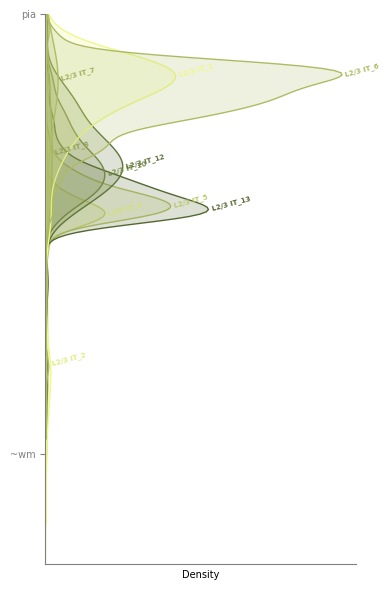

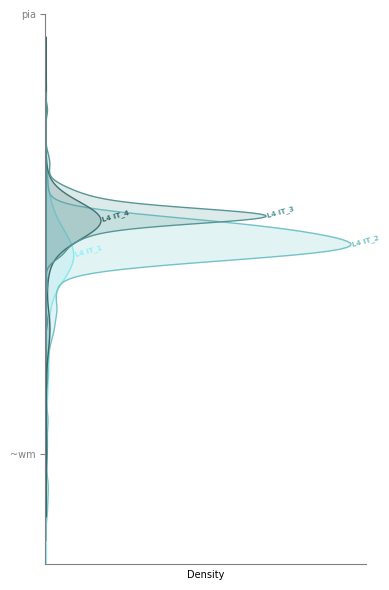

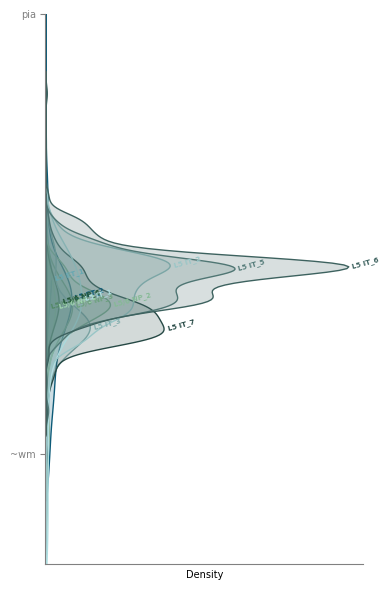

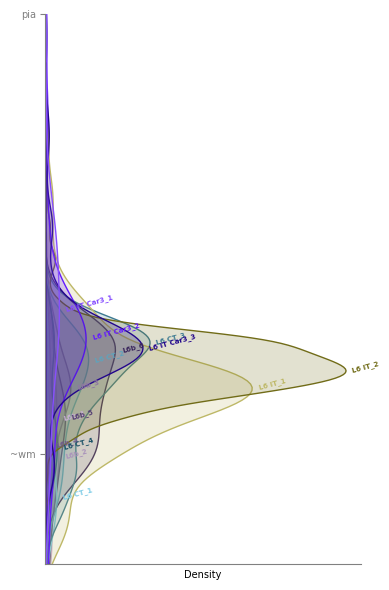

In [52]:
for layer in subclass_order_dict.keys(): 
    subclasses = subclass_order_dict[layer]
    layer_isodepth_df = isodepth_df[isodepth_df['SEAAD_Subclass_name'].isin(subclasses)]

    # KDE plot: depth along Y axis, split by cell type
    fig, ax = plt.subplots(figsize=(4, 6))

    plot_spatial_density_kde_with_labels(layer_isodepth_df, ax, 'scaled_gaston_isodepth', 'SEAAD_Supertype_name', 
                                         [t for t in ttype_order if t in layer_isodepth_df.SEAAD_Supertype_name.unique()], color_dict, label_peaks=True)


  SEAAD_Supertype_name    peak_x       peak_y
0            L2/3 IT_2  0.000007  2221.316615
1            L2/3 IT_3  0.000149  1266.642285
2            L2/3 IT_5  0.000315  1221.253886
3           L2/3 IT_13  0.000411  1240.214478
4           L2/3 IT_10  0.000149  1018.308688
5           L2/3 IT_12  0.000194   970.409629
6            L2/3 IT_8  0.000016   884.150850
7            L2/3 IT_7  0.000031   410.767490
8            L2/3 IT_1  0.000327   387.512673
9            L2/3 IT_6  0.000748   384.775141


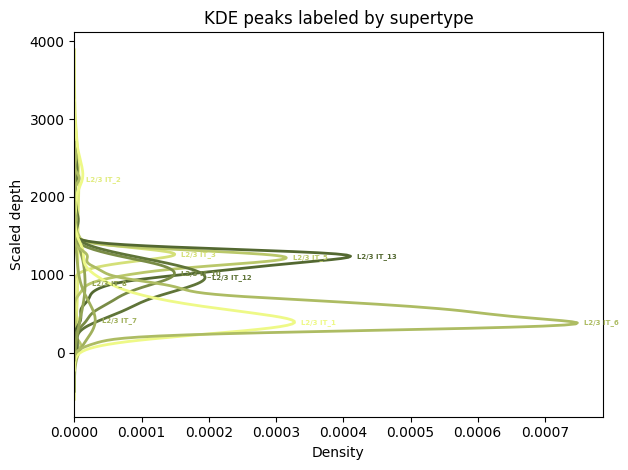

In [ ]:


# --- 1) initial plot (you already do this) ---
ax = sns.kdeplot(
    data=layer_isodepth_df,
    y='scaled_gaston_isodepth',
    hue='SEAAD_Supertype_name',
    hue_order=hue_order,
    palette=color_dict,
    fill=False,
    common_norm=True,
    alpha=0.2,
    linewidth=2,
    legend=False
)

# --- 2) map each drawn line back to its hue robustly ---
peaks = {}
used_hues = set()

# Precompute RGBA for your palette entries
palette_rgba = {h: mcolors.to_rgba(color_dict[h]) for h in hue_order if h in color_dict}

for line in ax.lines:
    x, y = line.get_data()
    if len(x) == 0:
        continue
    peak_idx = np.argmax(x)
    peak_x = float(x[peak_idx])
    peak_y = float(y[peak_idx])

    # Try to get hue from line label if seaborn embedded it
    label = line.get_label()
    mapped_hue = None
    if isinstance(label, str) and label in hue_order:
        mapped_hue = label

    # If label didn't help, match by color (RGBA)
    if mapped_hue is None:
        line_rgba = mcolors.to_rgba(line.get_color())
        # find unmatched hue with closest color
        candidates = [h for h in palette_rgba.keys() if h not in used_hues]
        if not candidates:
            continue
        # prefer exact-ish match
        for h in candidates:
            if np.allclose(line_rgba, palette_rgba[h], atol=1e-2):
                mapped_hue = h
                break
        # fallback: pick nearest by Euclidean distance in RGBA space
        if mapped_hue is None:
            mapped_hue = min(candidates, key=lambda h: np.linalg.norm(np.array(line_rgba) - np.array(palette_rgba[h])))

    peaks[mapped_hue] = {'peak_x': peak_x, 'peak_y': peak_y}
    used_hues.add(mapped_hue)

# Convert to DataFrame
peak_df = (
    pd.DataFrame.from_dict(peaks, orient='index')
      .reset_index()
      .rename(columns={'index': 'SEAAD_Supertype_name'})
)
print(peak_df)


# --- 3) clear and replot (or reuse axis) then overlay the correctly-matched peaks ---
ax.cla()
ax = sns.kdeplot(
    data=layer_isodepth_df,
    y='scaled_gaston_isodepth',
    hue='SEAAD_Supertype_name',
    hue_order=hue_order,
    palette=color_dict,
    fill=False,
    common_norm=True,
    alpha=1,
    linewidth=2,
    legend=False,
)

# --- add text labels near peaks ---
for _, row in peak_df.iterrows():
    hue = row['SEAAD_Supertype_name']
    peak_x = row['peak_x']
    peak_y = row['peak_y']

    # offset a bit to the right and up for visibility
    text_x = peak_x + 0.00001   # move 5% right of the peak
    text_y = peak_y          # same depth value

    ax.text(
        text_x,
        text_y,
        hue,  # the label text
        color=color_dict.get(hue, 'k'),
        fontsize=5,
        fontweight='bold',
        rotation=0,         # slight tilt
        rotation_mode='anchor',
        va='center',
        ha='left',
        zorder=10,
    )

ax.set_xlabel("Density")
ax.set_ylabel("Scaled depth")
ax.set_title("KDE peaks labeled by supertype")
plt.tight_layout()
plt.show()


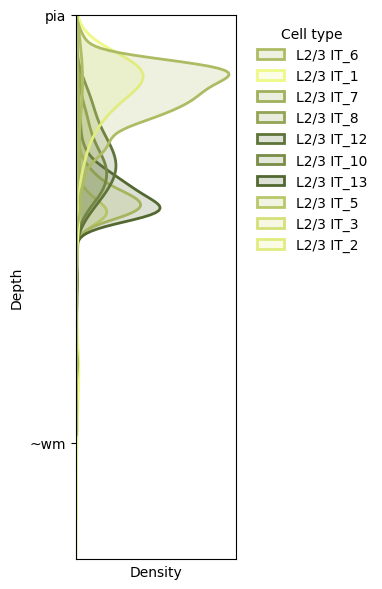

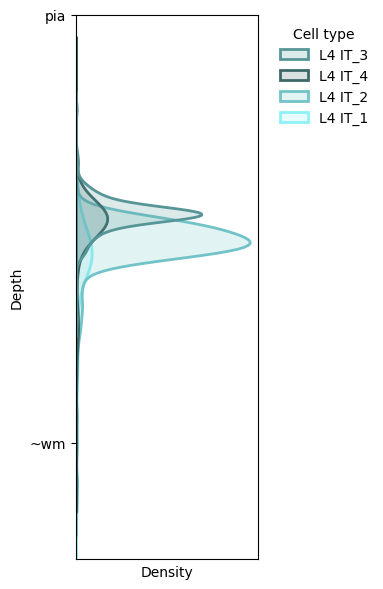

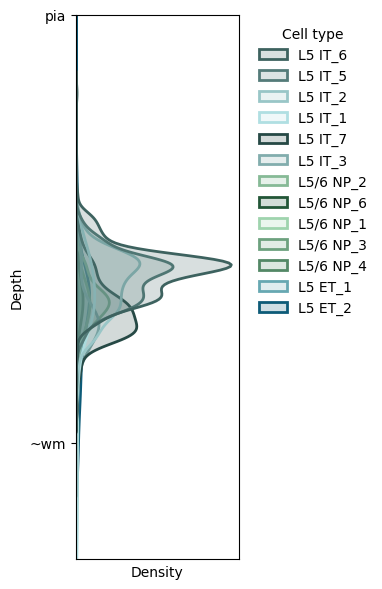

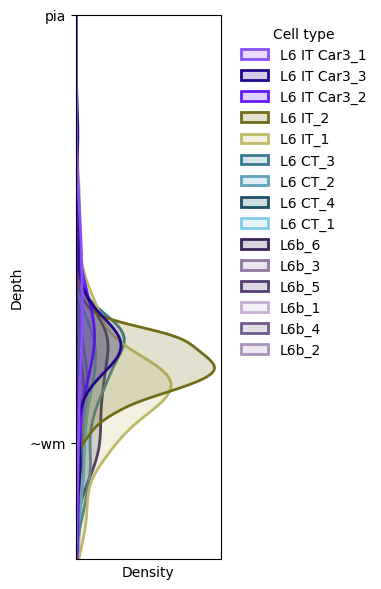

In [43]:

for layer in subclass_order_dict.keys(): 
    subclasses = subclass_order_dict[layer]
    layer_isodepth_df = isodepth_df[isodepth_df['SEAAD_Subclass_name'].isin(subclasses)]

    # KDE plot: depth along Y axis, split by cell type
    fig, ax = plt.subplots(figsize=(4, 6))
    sns.kdeplot(
        data=layer_isodepth_df,
        y='scaled_gaston_isodepth',
        hue='SEAAD_Supertype_name',
        hue_order=[t for t in ttype_order if t in layer_isodepth_df.SEAAD_Supertype_name.unique()],
        palette=color_dict,
        fill=True,
        common_norm=True,  # False means each cell type KDE integrates to 1 independently (good for comparing shapes of distributions regardless of sample sizes)
        alpha=0.2,
        linewidth=2
    )
    wm = 3500
    ax.set_ylim(0, wm) #standard isodepth range 
    ax.set_xticks([])      # remove x-axis ticks
    plt.xlabel("Density")
    plt.ylabel("Depth")
    plt.gca().invert_yaxis()  # optional: deeper depths lower on plot
    ax.grid(False)

    ax.set_yticks([0, 2750])      # remove x-axis ticks
    ax.set_yticklabels(['pia', '~wm'])      # remove x-axis ticks


    leg = ax.get_legend()
    if leg is not None:
        leg.set_bbox_to_anchor((1.05, 1))
        leg.set_loc('upper left')
        leg.set_title('Cell type')
        leg.set_frame_on(False)


    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, r'spatial_density_kde_{}.pdf'.format(layer.replace('/', '-'))), bbox_inches="tight", dpi=600)

    plt.show()


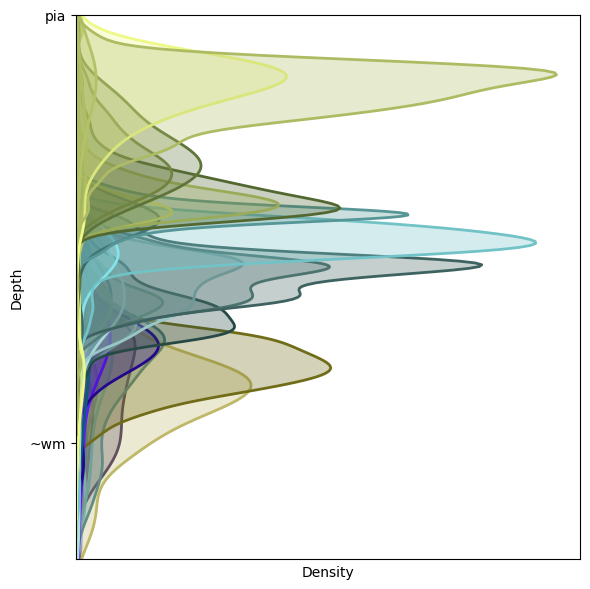

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))

# KDE plot: depth along Y axis, split by cell type
sns.kdeplot(
    data=isodepth_df,
    y='scaled_gaston_isodepth',
    hue='SEAAD_Supertype_name',
    hue_order=[t for t in ttype_order if t in isodepth_df.SEAAD_Supertype_name.unique()],
    palette=color_dict,
    fill=True,
    common_norm=True,  # False means each cell type KDE integrates to 1 independently (good for comparing shapes of distributions regardless of sample sizes)
    alpha=0.3,
    linewidth=2, 
    legend=False
)
wm=3500
ax.set_ylim(0, wm) #standard isodepth range 
ax.set_xticks([])      # remove x-axis ticks
plt.xlabel("Density")
plt.ylabel("Depth")
plt.gca().invert_yaxis()  # optional: deeper depths lower on plot
ax.grid(False)

ax.set_yticks([0, 2750])      # remove x-axis ticks
ax.set_yticklabels(['pia', '~wm'])      # remove x-axis ticks


leg = ax.get_legend()
if leg is not None:
    leg.set_bbox_to_anchor((1.05, 1))
    leg.set_loc('upper left')
    leg.set_title('Cell type')
    leg.set_frame_on(False)


plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'spatial_density_kde_ttypes.pdf'), bbox_inches="tight", dpi=600)

plt.show()


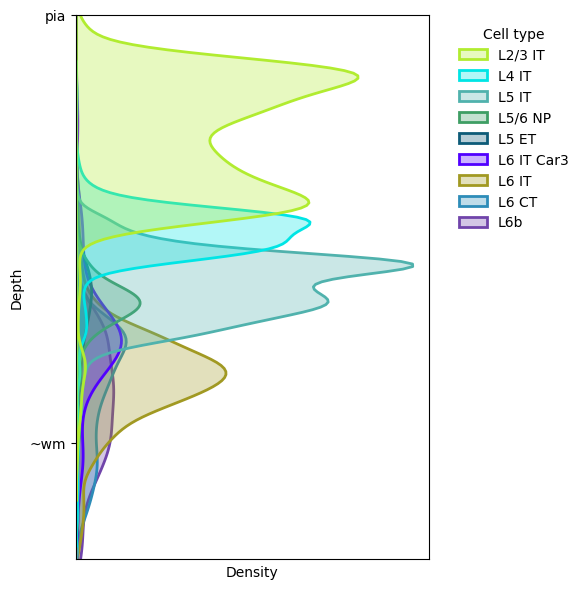

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))

# KDE plot: depth along Y axis, split by cell type
sns.kdeplot(
    data=isodepth_df,
    y='scaled_gaston_isodepth',
    hue='SEAAD_Subclass_name',
    hue_order=[t for t in subclass_order if t in isodepth_df.SEAAD_Subclass_name.unique()],
    palette=color_dict,
    fill=True,
    common_norm=True,  # False means each cell type KDE integrates to 1 independently (good for comparing shapes of distributions regardless of sample sizes)
    alpha=0.3,
    linewidth=2, 
    legend=True
)
wm=3500
ax.set_ylim(0, wm) #standard isodepth range 
ax.set_xticks([])      # remove x-axis ticks
plt.xlabel("Density")
plt.ylabel("Depth")
plt.gca().invert_yaxis()  # optional: deeper depths lower on plot
ax.grid(False)

ax.set_yticks([0, 2750])      # remove x-axis ticks
ax.set_yticklabels(['pia', '~wm'])      # remove x-axis ticks


leg = ax.get_legend()
if leg is not None:
    leg.set_bbox_to_anchor((1.05, 1))
    leg.set_loc('upper left')
    leg.set_title('Cell type')
    leg.set_frame_on(False)


plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'spatial_density_kde_subclasses.pdf'), bbox_inches="tight", dpi=600)

plt.show()
